In [7]:
%matplotlib inline

In [161]:
from __future__ import division, print_function
import sys,os
import numpy as np, scipy as sp, pandas as pd
import scipy.io
import scipy.signal as signal
import scipy.fftpack as fftpack
from scipy import special, interpolate
import matplotlib.pyplot as plt
import matplotlib

from imp import reload
import glob

In [17]:
os.chdir('/home/mike/ve/ml/')

In [242]:
from eegkaggle.vectorizers import naive, spectral
from eegkaggle.dio import dataio
from eegkaggle.plotting import plotstuff
from eegkaggle.msignal import wavelets, metrics, auxfilter, msig
from eegkaggle.models import neural

In [12]:
matplotlib.style.use('ggplot')

In [108]:
ssmall,smed, slarge, slong = (4,3), (8,6), (16,10), (16,4)
matplotlib.rcParams['figure.figsize'] = slarge

Functions

Data loading section

In [14]:
def vectorize_fft(path, ndim=800, # number of vector dimensions to output
                  cutoff=40, # hard cutoff frequency
                  fs=400, # sample frequency of input signal
                  takeLog=True, # take log of freq spectrum
                  avgChan=False, # take average across all channels
                  stdChan=False, # take stdDev across all channels - VERY INTERESTING
                  sepComplex=False, # prolly don't need this
                  hilbertize=False): # don't need this right now
    rawdata = matlabtools.get_matlab_eeg_data(path)['data']
    spectrum = ftpk.fft(rawdata, axis=0)
    nsamp0 = rawdata.shape[0]
    t = np.linspace(0, fs, nsamp0)
    cutIndex = cutoff*nsamp0/fs
#     plt.plot(t[:cutIndex],np.abs(spectrum[:cutIndex]))
#     plt.plot(t, spectrum)
    if avgChan:
        spectrum = np.mean(spectrum, axis=1)
    elif stdChan:
        spectrum = np.std(spectrum, axis=1)
    spectrum = np.abs(spectrum[:cutIndex])
    rs_spectrum = signal.resample(spectrum, ndim, axis=0)
    rs_t = np.linspace(0, cutoff, ndim)

#     print(rs_spectrum.shape)
#     print(np.angle(spectrum[:cutIndex]).shape)
#     plt.plot(t[:cutIndex], np.angle(spectrum[:cutIndex, 0]))
    """ Phase information at this point looks really nasty, so will ignore it"""

    if takeLog:
        rs_spectrum = np.log(rs_spectrum)
        
#     plt.plot(rs_t, rs_spectrum)
    return rs_spectrum

def spectrogram(path, nchunk=1024, 
                windowStep=4, # subdivide the chunk size in order to get a rolling window
                absLog=False,
                hardCutoff=100,
                fs=400
               ):
    rawdata = matlabtools.get_matlab_eeg_data(path)['data']
    nsamp0 = rawdata.shape[0]
    spec_ary = []
    cutIndex = hardCutoff*nchunk/fs

    step = nchunk//windowStep
    for i in range(0, nsamp0, step):
        spectrum = ftpk.fft(rawdata[i:i+nchunk], axis=0)[:cutIndex]
        if spectrum.shape[0] == cutIndex: # discard data that doesn't fit right because it messes up the array
            spec_ary.append(spectrum)
#             print(spectrum.shape)
    spec_ary = np.array(spec_ary)
    if absLog:
        spec_ary = np.log(np.abs(spec_ary))
    else:
        spect_ary = np.abs(spec_ary)

    return spec_ary

    


In [19]:
basepath= '/home/mike/data/train/'
sources1 = glob.glob(basepath + '*_1.mat') 
sources0 = glob.glob(basepath + '*_0.mat') 
sourcesT = glob.glob(basepath + '*.mat')
print(len(sources0), len(sources1), len(sourcesT))

5592 450 6042


In [20]:
# plt.plot(vectorize_fft(sources0[0], avgChan=1))
# plt.plot(vectorize_fft(sources1[0], avgChan=1))

In [21]:
# plt.plot(vectorize_fft(sources0[datanum], stdChan=1))
# plt.plot(vectorize_fft(sources1[datanum], stdChan=1))

Keras layer structure
option 1: take FFT, concat all the electrodes, feed into MLP (sigmoid). Dense 3 layer, 1-hot output. 
linearity bad. Reduce features (pca, smoothing, manual decimation) 
option 2: same, but with convo, max pooling instead of dimensionality reduction
option 3: noob feature vector maker (1600 per slice). feed into MLP as above.
option 4: NFV and use deep belief network (needs extensions)

In [22]:
datanum = 9
print(sources0[datanum], sources1[datanum])

/home/mike/data/train/2_727_0.mat /home/mike/data/train/3_115_1.mat


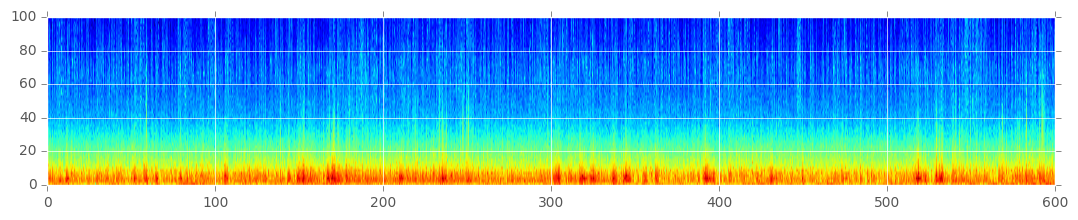

In [26]:
matplotlib.rcParams['figure.figsize'] = (13,2.4)
datanum = 1
gram0 = spectral.spectrogram(dataio.get_matlab_eeg_data_ary(sources0[datanum]), absLog=1)
gram1 = spectral.spectrogram(dataio.get_matlab_eeg_data_ary(sources1[datanum]), absLog=1)
grams = [gram0, gram1]

gram0.shape
ng = 0
for i in range(20):
#     plt.imshow(grams[ng][:,:,i].T, origin='lower', extent=[0, 600, 0, 100])
#     plt.savefig('../pics/gram_{}_{}_{:02d}.jpg'.format(datanum, ng,i))
    plt.imshow(np.average(grams[ng][:,:], axis=2).T, origin='lower', extent=[0, 600, 0, 100])
#     plt.savefig('../pics/avg_e/agram_{}_{}.jpg'.format(datanum, ng))

In [67]:
reload(dataio), reload(spectral)

(<module 'eegkaggle.dio.dataio' from 'eegkaggle/dio/dataio.pyc'>,
 <module 'eegkaggle.vectorizers.spectral' from 'eegkaggle/vectorizers/spectral.py'>)

eegkaggle/vectorizers/spectral.py:125: RuntimeWarning: divide by zero encountered in log
  if mode=='abslog':


(3749, 128, 16)


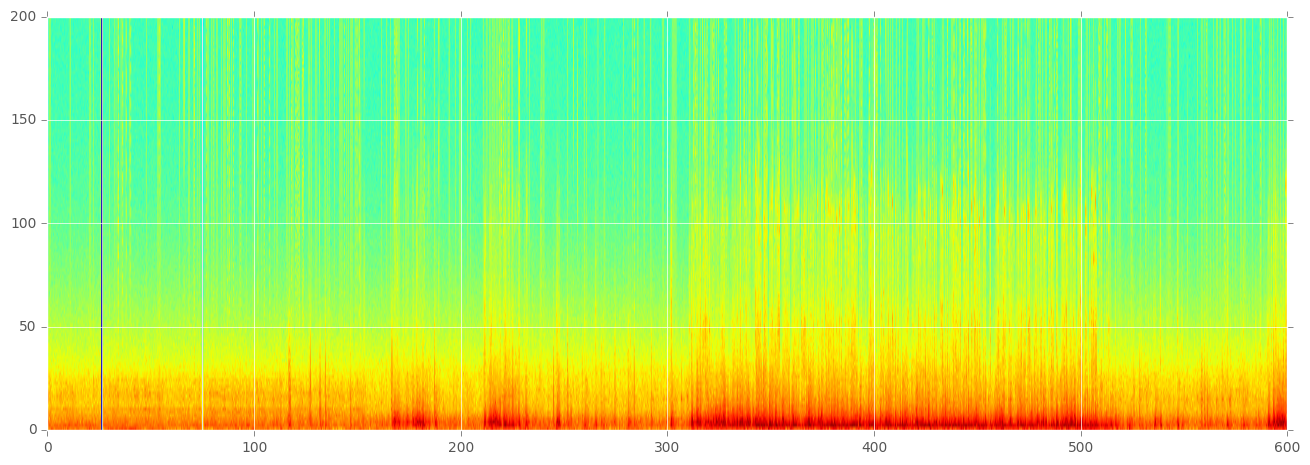

In [150]:
d0 = dataio.get_matlab_eeg_data_ary(sources0[600])
d1 = dataio.get_matlab_eeg_data_ary(sources1[13*6-2])
gram0 = spectral.spectrogram(d0, absLog=1, hardCutoff=200)
gram1 = spectral.spectrogram(d1, absLog=1, hardCutoff=200)

print(gram0.shape)
# plt.imshow(np.mean(gram0, axis=2).T)
spectral.spec_to_fig(gram1, cutoff=200)

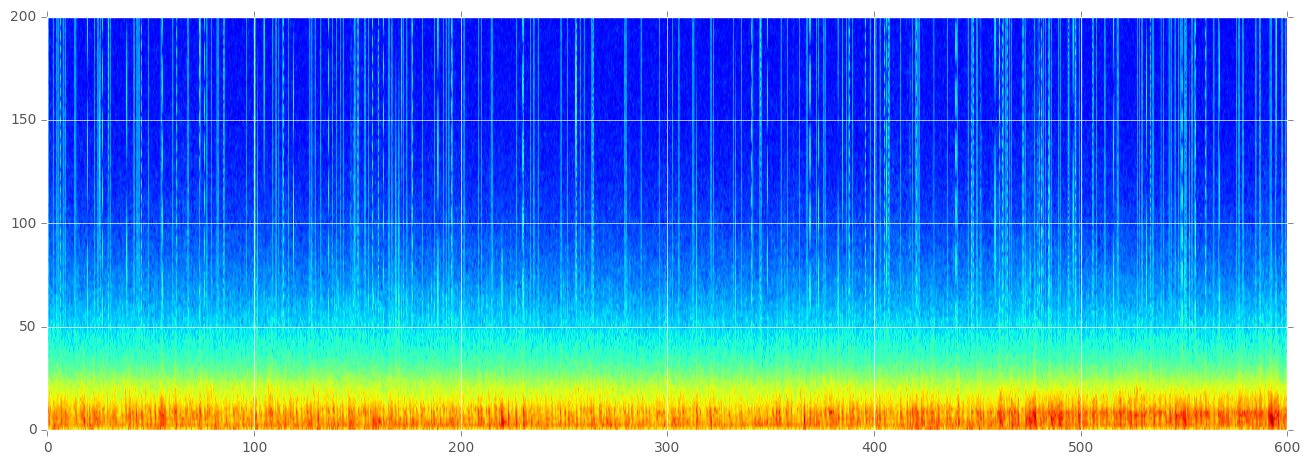

In [151]:
spectral.spec_to_fig(gram0, cutoff=200)

In [152]:
# plt.plot(d1)
''

''

In [128]:
ft0 = spectral.vectorize_fft(d0, takeLog=True)
ft1 = spectral.vectorize_fft(d1, takeLog=True)

In [84]:
120000/400

300.0

In [153]:
down = 120
ft0 = fftpack.fft(d0, axis=0)
ft1 = fftpack.fft(d1, axis=0)
a0 = np.abs(ft0)[:len(ft0)//2]
a1 = np.abs(ft1)[:len(ft0)//2]
a0 = signal.resample_poly(a0, 1, down, axis=0)
a1 = signal.resample_poly(a1, 1, down, axis=0)

l0 = np.log(a0)
l1 = np.log(a1)


''

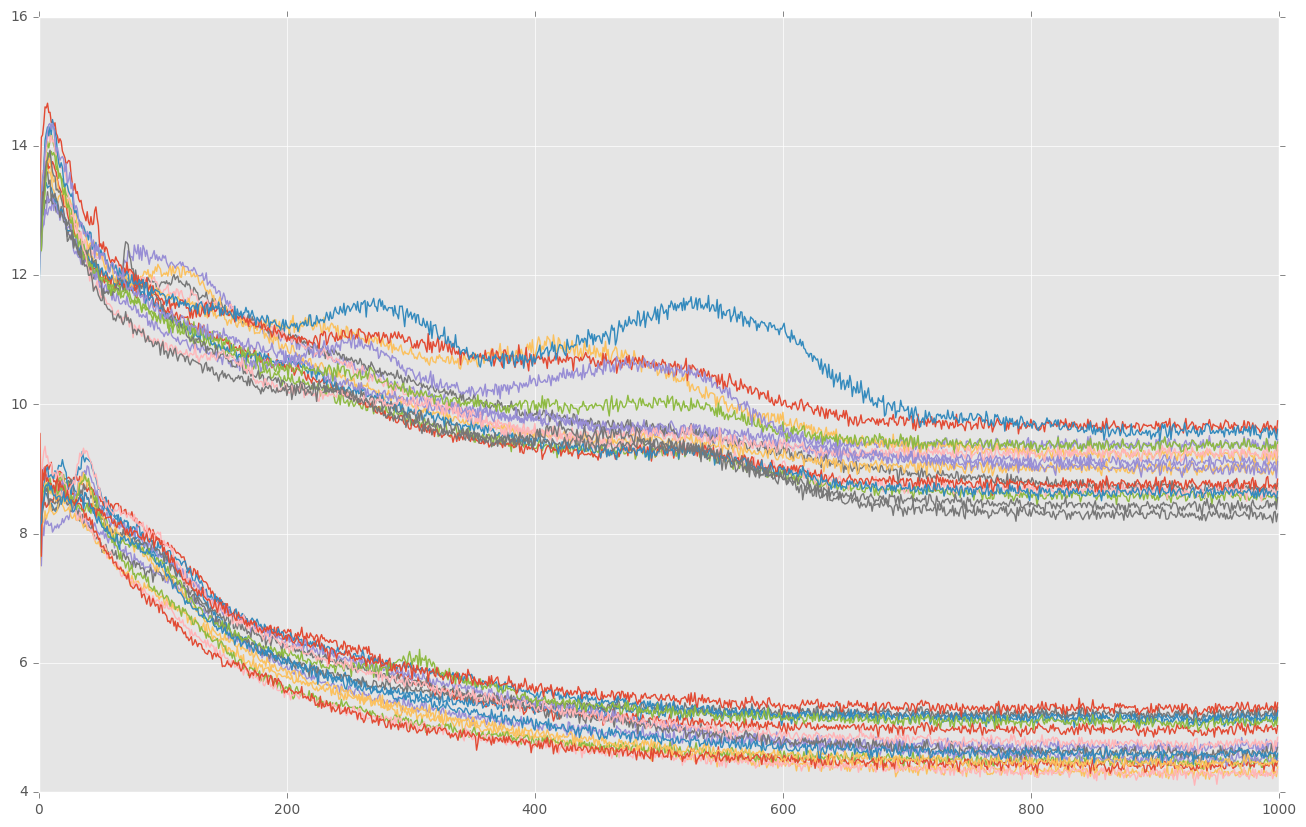

In [155]:
cut = 4000
plt.plot(l0[:cut]-2)
plt.plot(l1[:cut]+2)
''

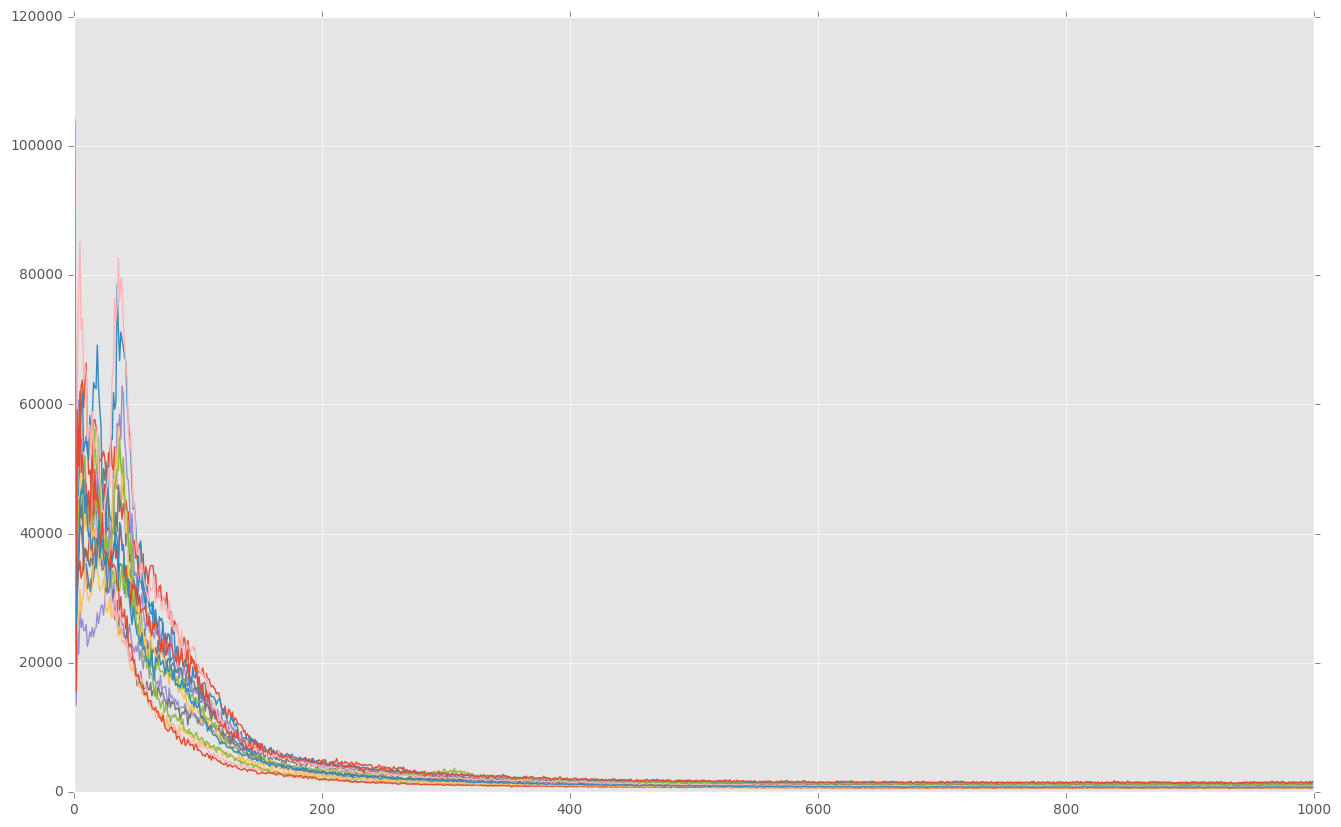

In [156]:
plt.plot(a0)

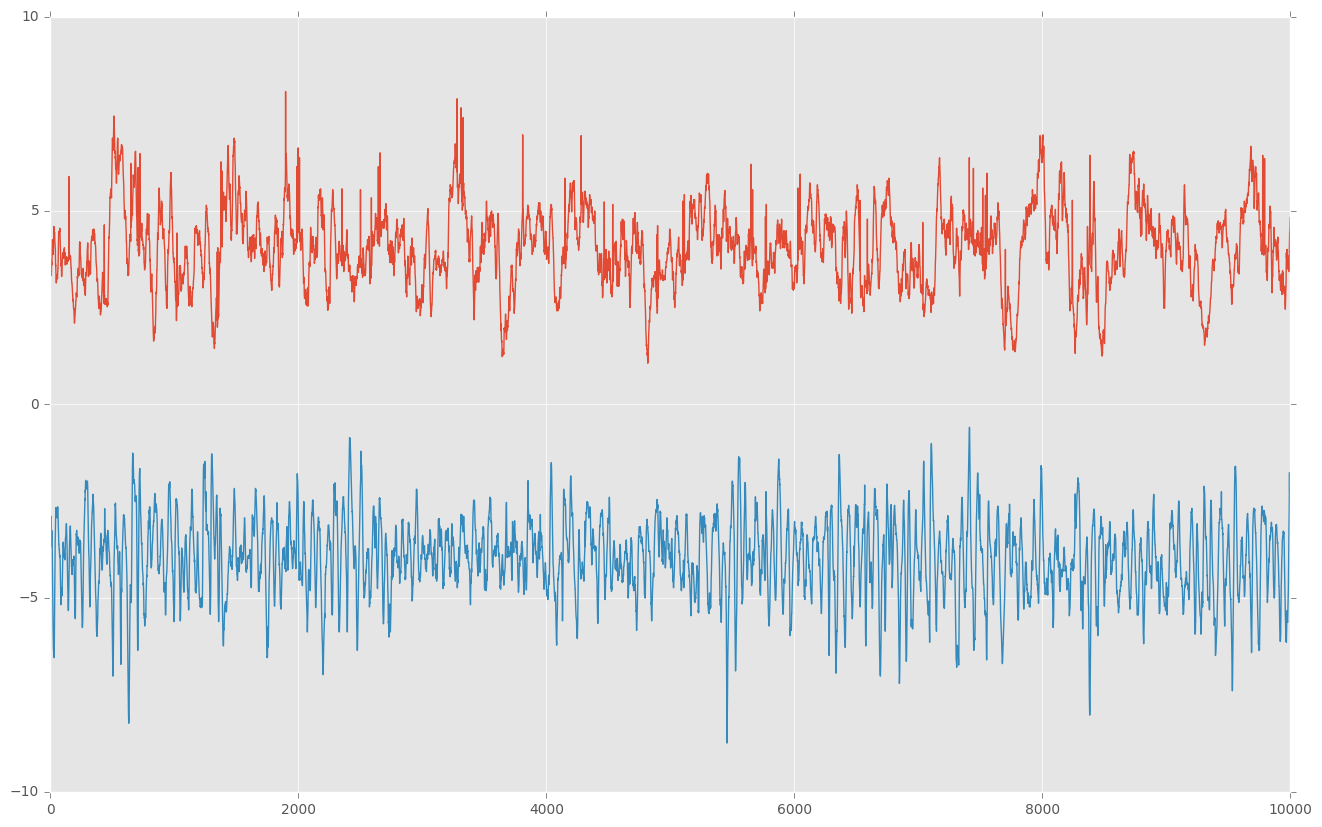

In [123]:
t = 30000
n = 10000
ch = 10
p0 = d0[t:n+t, ch]
p1 = d1[t:n+t, ch]
plt.plot(p0/np.std(p0) + 4)
plt.plot(p1/np.std(p1) - 4)

In [212]:
hard_cutoff=200
smoothing_cutoff=200
fs=400
ndim=4000
down=60
log_low_cut=-5
ftsig = fftpack.fft(d0, axis=0)
ftsig_a = np.abs(ftsig[:len(ftsig)*hard_cutoff//fs])
# Smooth it with low pass and downsample. Low pass may not be necessary since resample does appropriate
# pre-filtering
ftsig_r = signal.resample_poly(ftsig_a, 1, 60)#auxfilter.butterfilt(ftsig_a, smoothing_cutoff, fs)
# ftsig_r = ftsig_a #signal.resample(ftsig_f, ndim)

# Ok, now the weird bit. Take the existing x-domain and create an interpolation image of it
t_rs = np.linspace(0.0001, hard_cutoff, len(ftsig_r))
fn_ftsig_rs = interpolate.Akima1DInterpolator(t_rs, ftsig_r)

''

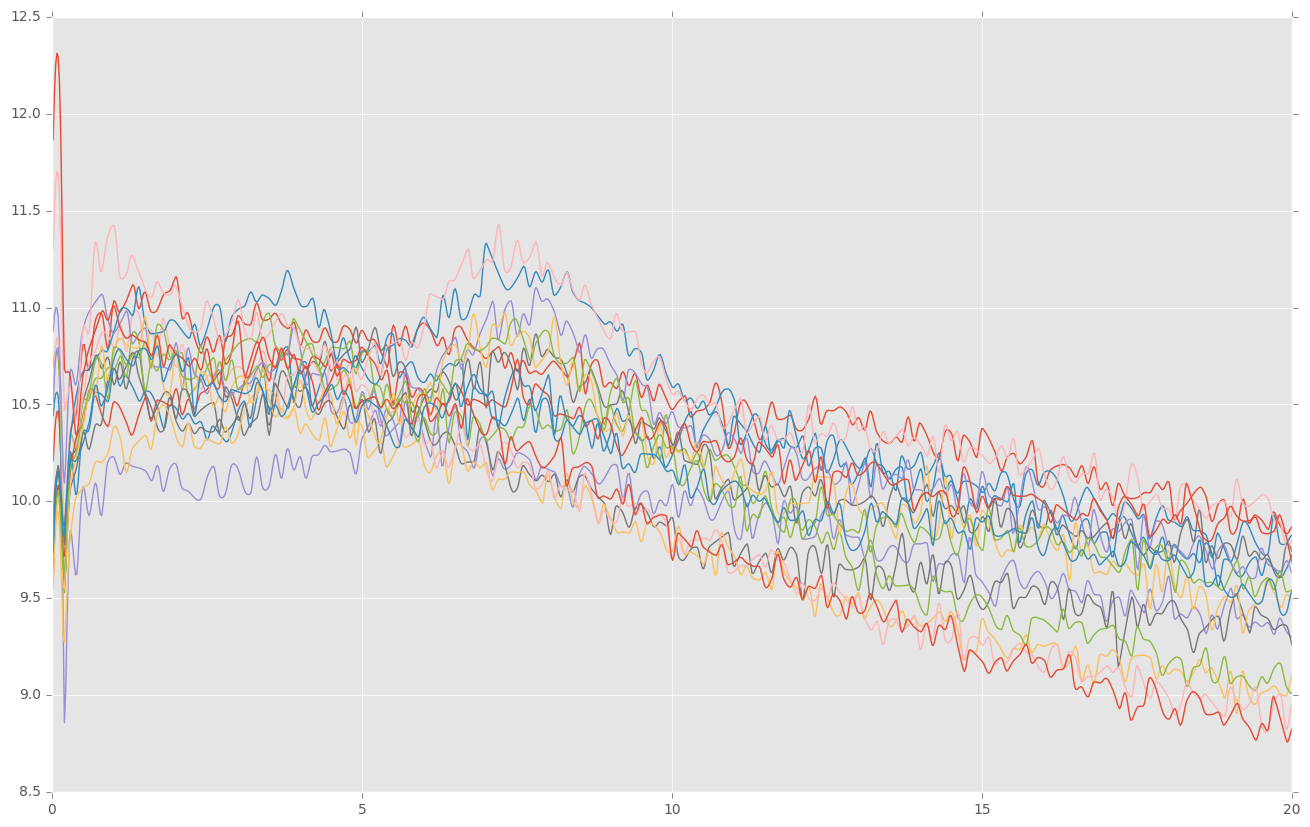

In [214]:
x = np.linspace(0,20, 1000)
plt.plot(x, np.log(fn_ftsig_rs(x)))
''

-2.32192809489


''

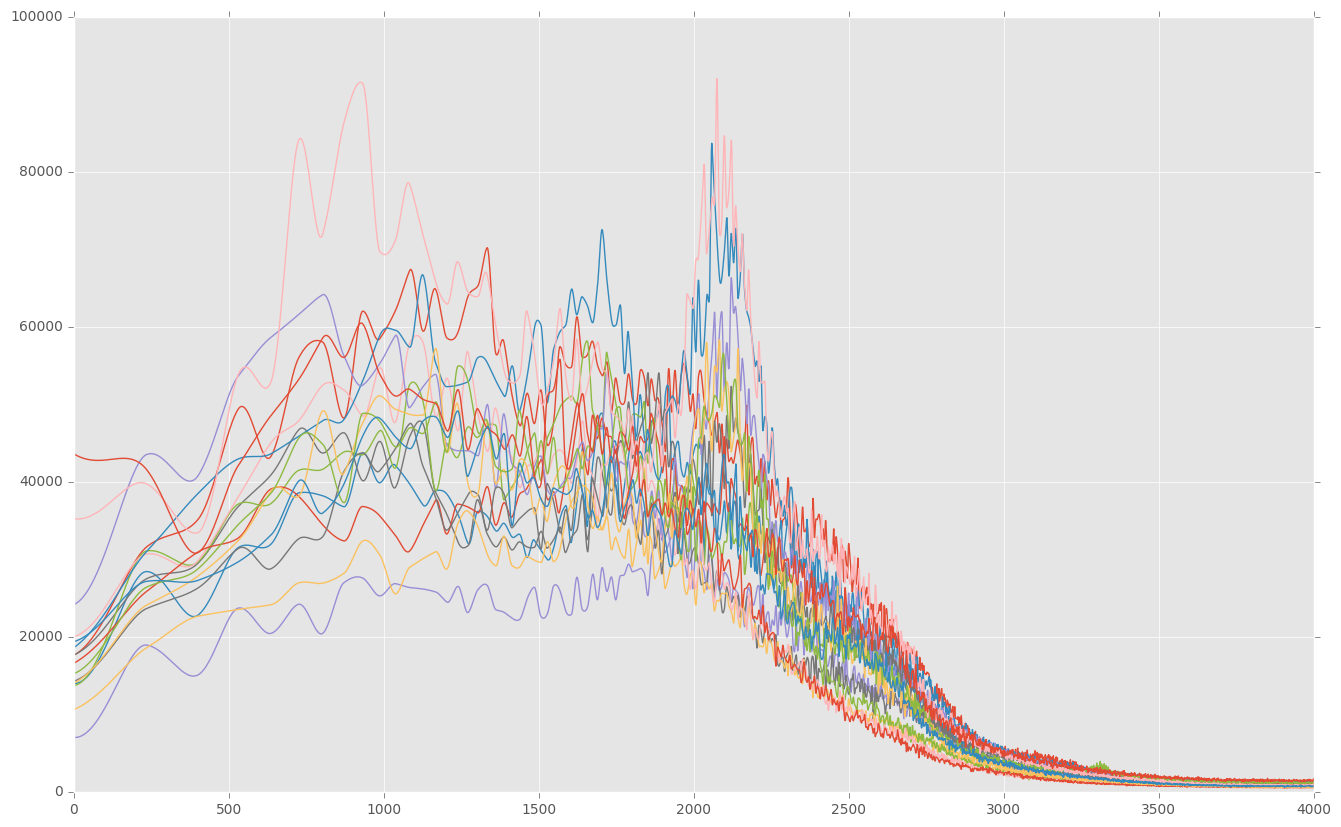

In [215]:
# And now map an exponential domain, thereby creating a higher density of points around the main freq
log_low_cut=np.log2(.2)
print(log_low_cut)
x_log = np.linspace(log_low_cut, np.log2(hard_cutoff), ndim)
log_ftsig = fn_ftsig_rs(np.power(2, x_log))
quad_ftsig = fn_ftsig_rs(x_log**2)
plt.plot(log_ftsig)
''

''

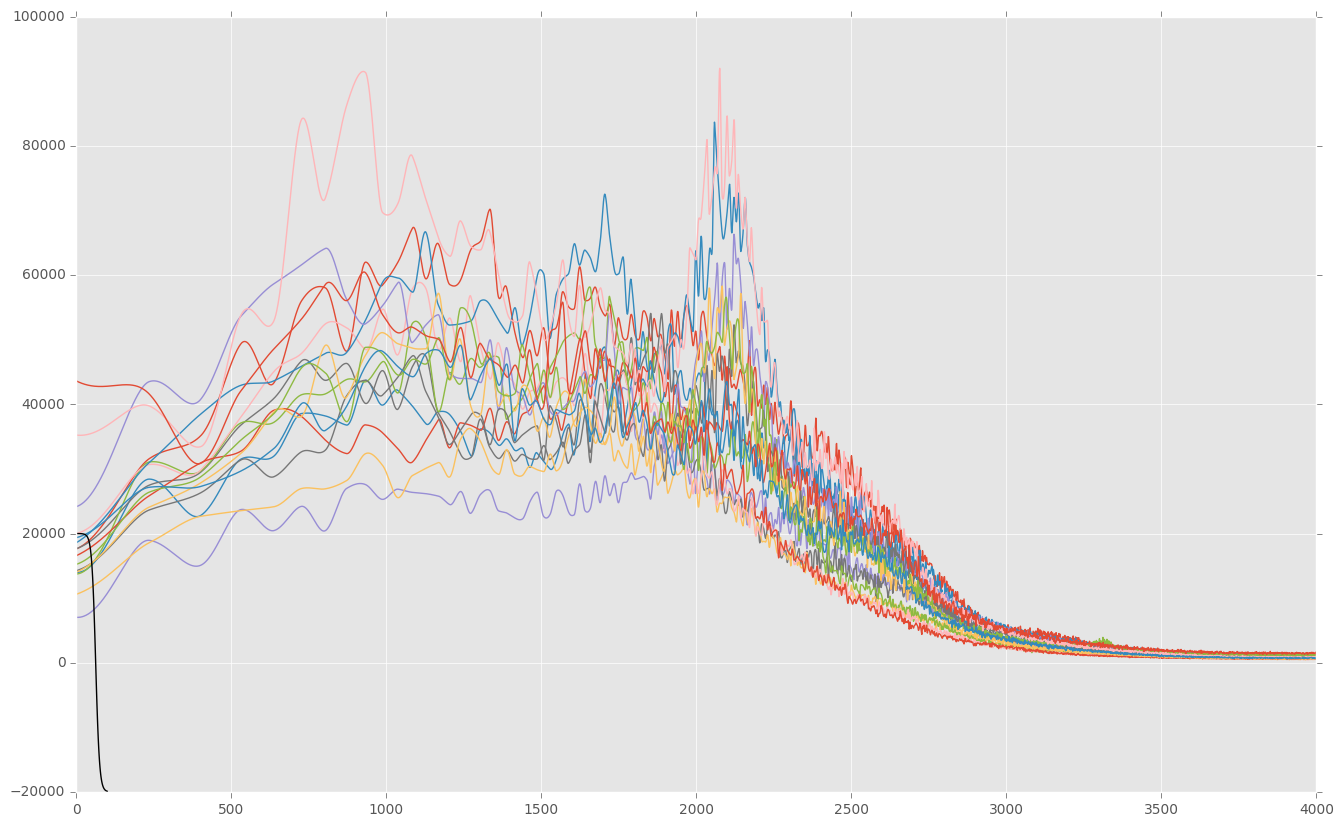

In [259]:
# plt.plot(log_ftsig*(x_log.reshape(-1,1)))
plt.plot(log_ftsig)


''

In [225]:
reload(spectral)

<module 'eegkaggle.vectorizers.spectral' from 'eegkaggle/vectorizers/spectral.py'>

In [240]:
d0z = msignal.norm_softclip(d0, norm_by_chan=0)
rt = spectral.ridiculous_log_transform(d0z, down=30)

(1024, 16)


''

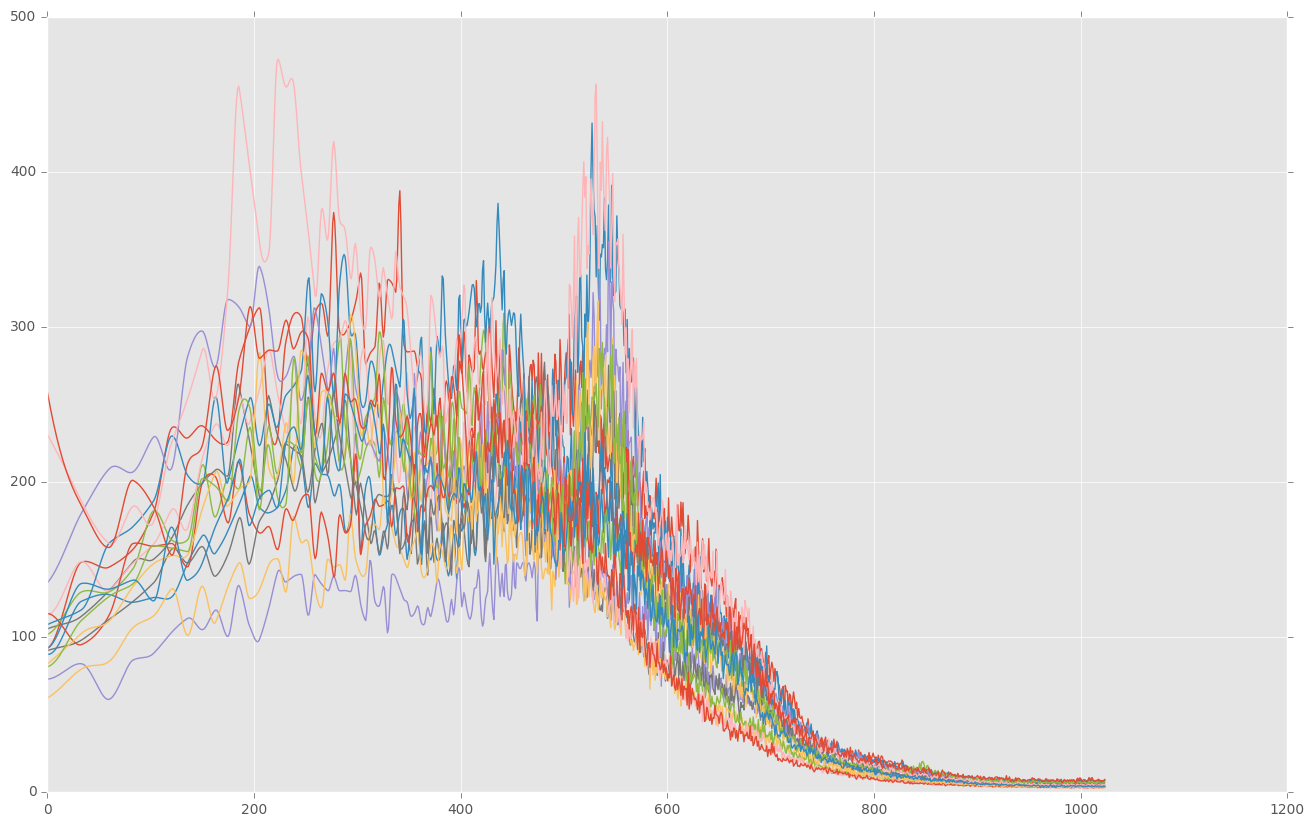

In [282]:
def softplus2(x, a=1):
    return np.log(1+np.exp((x+1)*a))/a -1

print(rt.shape)
plt.plot((rt))
x = np.linspace(0,rt.shape[0], 100)
# plt.plot(msig.softplus2((800-x/10), 1), 'k')
''